# COVID Classification Challenge

In this challenge you will train a classifier to distinguish chest x-ray images of patients with no lung conditions, those with pneumonia, and those with COVID-19. Your network is expected to accept patches of images with shape (1,320,320) and predict a classification for each: 0 for normal, 1 for pneumonia, and 2 for COVID.

The training set in `training_data.zip` contains a few normal and pneumonia patients but is primarily COVID cases. Included is a pre-trained network which can distinguish between normal and pneumonia patients only, this can be used however you like to train your own classifier or not used at all, however it's training set of normal/pneumonia images is much larger than what you are provided.

The testing data in `test_data.zip` is a mix of all three categories with which your classifier will be assessed. The criteria for this challenge is overall accuracy of your predictions for this set, runtime performance, and consideration for implementation. 

This notebook has some starter code for loading the data and the pre-trained network, as well as the routine to run to generate your prediction on the test set.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob
import timeit
import datetime
import getpass

import monai
from monai.data import PILReader, Dataset, DataLoader
from monai.networks.nets import Classifier
from monai.transforms import (
    LoadImage,
    Lambda,
    AddChannel,
    Resize,
    Compose,
    ToTensor,
)

The following starter code assumes the data zip files are unpackaged, this can be done here or manually:

In [ ]:
%%bash

if [ ! -d training_data ] ; then unzip -q training_data.zip; fi
if [ ! -d test_data ] ; then unzip -q test_data.zip; fi

### Pre-trained Network Loading

In the next cell we create an instance of `Classifier` which has the same structure as the pre-trained network. We then load the pre-trained network and load its weights into the newly created one. 

In [ ]:
net = Classifier(
    in_shape=(1, 320, 320),
    classes=2,
    channels=[4, 8, 16, 32, 64],
    strides=[2, 2, 2, 2, 2],
    dropout=0.25,
)

pretrained = torch.jit.load("classifier_normal_pneumonia.zip")
net.load_state_dict(pretrained.state_dict())

### Data Loading

Loading the training or test data is straight-forward with a subclass of `Dataset`. The provided transforms are used to regularize the shape of the loaded images only so should be only consider the base essentials of a training data pipeline. Similarly the `CovidImageDataset` class need not inherit from `Dataset` specifically. It's up to you to choose how to split this data into train/validation/test sets, and choose which augmentations to apply.

torch.Size([1, 320, 320]) 2


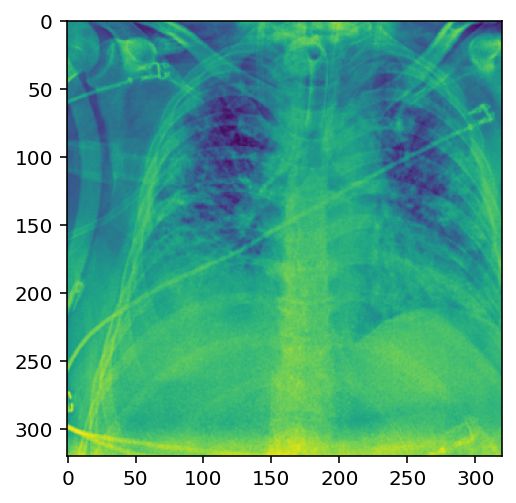

In [24]:

crop_size = (320, 320)  # size of images expected by the pre-trained network


class CovidImageDataset(Dataset):
    """
    Construct a dataset of x-ray images, selecting the label based on file name. 
    If the file name isn't given a category (ie. test images), it's label will be -1.
    Feel free to change this class to speed things up but don't change it's behaviour.
    """

    def __init__(self, image_dir, transform):
        image_files = sorted(glob.glob(image_dir + "/*.png"))

        super().__init__(data=image_files, transform=transform)

        def get_label(filename):
            """Choose a label for the given image based on its file name."""
            if "normal_" in filename:
                return 0

            if "pneumonia_" in filename:
                return 1

            if "covid_" in filename:
                return 2

            return -1

        self.labels = list(map(get_label, image_files))

    def __getitem__(self, index):
        return super().__getitem__(index), self.labels[index]


train_transforms = Compose(
    [
        LoadImage(image_only=True, reader=PILReader()),  # Load each image
        Lambda(lambda im: im if im.ndim==2 else im[...,0]),  # many images are grayscale so select red channel
        AddChannel(),  # add a 1-size channel dimension
        Resize(crop_size, "area"),  # resize (crop or pad with 0) to the given size
        ToTensor(),
    ]
)

train_ds = CovidImageDataset("./training_data", train_transforms)

im, label = train_ds[371]

print(im.shape, label)
plt.imshow(im[0])

### Test Routine

This routine will apply the test images to the given network (or any other callable accepting batches of images and returning a label tensor) and save the predictions with total runtime value to an output file. This should run once your network is done training to generate the submission file you will hand in as your results. This will contain the predictions and the average runtime your network took to predict for a batch of 100. 

**Please don't modify any of the code in this routine!**

In [ ]:
def predict(net, test_data_dir="./test_data", device=0, timeit_count=10, notebook_file="challenge.ipynb"):
    """
    Predict the classification for images in the test set using the calleable `net`. The test
    data is expected to be found in `test_data_dir`. Batches will be moved to device `device`.
    The prediction will be run `timeit_count` number of times over the dataset to get an 
    average runtime value.
    """
    def choose_channel(img):
        return img[...,0] if img.ndim==3 else img

    test_transforms = Compose(
        [
            LoadImage(image_only=True, reader=PILReader()),
            Lambda(lambda im: im if im.ndim==2 else im[...,0]),
            AddChannel(),
            Resize(crop_size, "area"),
            ToTensor(),
        ]
    )

    test_ds = CovidImageDataset(test_data_dir, test_transforms)
    test_loader = DataLoader(test_ds, batch_size=100, num_workers=10)

    predictions = []

    # apply the network to predict a label for each image
    with torch.no_grad():
        for batch, _ in test_loader:
            pred = net(batch.to(device))
            pred = pred.argmax(1)
            predictions.append(pred)

    # do prediction again on a single batch using timeit to get an average network runtime
    test_batch, _ = monai.utils.first(test_loader)
    test_batch = test_batch.to(device)

    with torch.no_grad():
        time = timeit.timeit(lambda: net(test_batch), number=timeit_count)

    predictions = torch.cat(predictions)
    time /= timeit_count

    pred_filename_pattern = f"predictions_{getpass.getuser()}_%Y%m%d%H%M%S.npz"
    pred_filename = datetime.datetime.now().strftime(pred_filename_pattern)
    
    try:
        with open(notebook_file) as o:
            notebook = o.read()
    except IOError:
        notebook = "Not found"

    np.savez_compressed(pred_filename, predictions=predictions.cpu().numpy(), time=time, notebook=notebook)

    return pred_filename, time, predictions


# As an example we'll use the pre-trained network, this will work but do poorly since it can't
# predict COVID images. We pass in `net.to(0).eval()` but the argument can be any callable.
pred_filename, time, preds = predict(net.to(0).eval())

### Good Luck!

We've given you the basic code to load data and run prediction, it's now up to you to train a network to do the three part classification. Once your network is trained use `predict` to generate the prediction file and send that in to us as your submission for the challenge.